In [1]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT') 
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
model.eval() #sets model in evaluation mode

filename = "testset/zebra.jpg"

input_image = Image.open(filename)
#input_image = input_image.resize([512, 512]) # for large images
input_image = input_image.convert("RGB")


In [2]:
# The images have to be loaded in to a range of [0, 1] and then normalized using the following mean and std 
preprocess = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model(adds 1 more dimension to tensor)
#display(input_batch.shape) #[1, 3, 382, 272]

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)  # To get the maximum prediction of each class
display(output_predictions.shape)


torch.Size([376, 564])

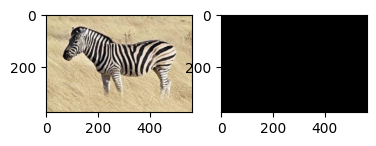

In [3]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.subplot(1, 3, 2)
plt.imshow(r)
plt.show()


In [4]:
'''
aspp_layer = model.classifier[4]
display(aspp_layer)
aspp_features = aspp_layer.weight.data.numpy()
display(aspp_features.shape)
'''
# retrieving aspp layer features 
aspp = torchvision.models.segmentation.deeplabv3.ASPP(in_channels=3, atrous_rates=[6, 12, 18])
aspp.eval()

aspp_features = aspp.forward(input_batch)
aspp_features = aspp_features.squeeze(0)
#display(aspp_features)
display(aspp_features.shape)

torch.Size([256, 376, 564])

In [5]:
import cv2
import numpy as np


def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create Numpy arrays containing zeros.
    # Later to be used to fill them with respective red, green, and blue pixels.
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(colors)):
        index = labels == label_num
        
        R, G, B = colors[label_num]

        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1   # transparency for the original image
    beta = 0.8  # transparency for the segmentation map
    gamma = 0   # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    
    return image
     

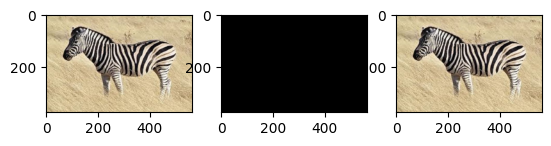

In [6]:
def perform_inference():
    # Get RGB segmentation map
    segmented_image = draw_segmentation_map(output)

    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, input_image.size, cv2.INTER_LINEAR)
    overlayed_image = image_overlay(input_image, segmented_image)

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.subplot(1, 3, 2)
    plt.imshow(r)
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    
    return

perform_inference()

In [7]:
# Applying PCA to ASPP features
from sklearn.decomposition import PCA


features = aspp_features.detach().numpy()
reshaped_aspp = features.reshape(256, features.shape[1]*features.shape[2])  # Reshape to [256, HEIGHT * WIDTH] (pca is applied to 2d data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(reshaped_aspp.T).T # Transpose for the correct shape
pca_features = principalComponents.reshape(2, *features.shape[1:]) 

display(pca_features.shape)


(2, 376, 564)

In [8]:
# Convert original image to LAB color space
from skimage import color 


lab_image = color.rgb2lab(input_image)
lab_image = np.transpose(lab_image, (2, 0, 1))
display(lab_image.shape)

pca_lab_sum = np.concatenate((pca_features, lab_image), axis=0)
display(pca_lab_sum.shape)

(3, 376, 564)

(5, 376, 564)

In [9]:
#torch.set_printoptions(threshold=input_image.size[0] * input_image.size[1])
#print(output_predictions) 

# Check if any object was recognised
def has_objects():
    return (output_predictions != 0).any()


# Updates if no object was recognised
def update_no_objects_found(new_pca_lab_sum):
    w = 0.2
    new_pca_lab_sum[:2] = pca_lab_sum[:2] * w
    new_pca_lab_sum[2:] = pca_lab_sum[2:] * (1-w)


# Updates if at least one object was recognised
def update_objects_found(new_pca_lab_sum):
    w = 0.1
    for i in range(output_predictions.shape[0]):
        for j in range(output_predictions.shape[1]):
            if output_predictions[i][j] == 0:
                new_pca_lab_sum[:2, i , j] = pca_lab_sum[:2, i, j] * w
                new_pca_lab_sum[2:, i , j] = pca_lab_sum[2:, i, j] * (1-w)
            else:
                new_pca_lab_sum[:, i , j] = 0


print("Object found = ", has_objects())
new_pca_lab_sum = np.zeros(pca_lab_sum.shape)

if has_objects() == False:
    update_no_objects_found(new_pca_lab_sum)
else:
    update_objects_found(new_pca_lab_sum)

def print_updates():
    for i in range(new_pca_lab_sum.shape[0]):
        for j in range(new_pca_lab_sum.shape[1]):
            for k in range(new_pca_lab_sum.shape[2]):
                print(new_pca_lab_sum[i, j, k])

#print(new_pca_lab_sum) 

Object found =  tensor(False)


In [10]:
# Silhouette score for ideal n_clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


k = [3, 4, 5, 6]
d2_new_pca_lab_sum = new_pca_lab_sum.reshape(5, new_pca_lab_sum.shape[1] * new_pca_lab_sum.shape[2])
for n_clusters in k:
    km = KMeans(n_clusters=n_clusters, n_init=10)
    preds = km.fit_predict(d2_new_pca_lab_sum)
    centers = km.cluster_centers_
    
    score = silhouette_score(d2_new_pca_lab_sum, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))


For n_clusters = 3, silhouette score is 0.5591888824745953)
For n_clusters = 4, silhouette score is 0.34276033981122095)


ValueError: Number of labels is 5. Valid values are 2 to n_samples - 1 (inclusive)